![title](../data/imgs/boosting13.png)

Como vimos, Gradient Boosted Decision Trees é uma tecnica de Boosting que utiliza Stumped Decision Trees para a melhora gradual do modelo.

Mas como que isso é feito?

![title](../data/imgs/boosting12.png)

Esse ciclo é repetido de formas sucessivas enquanto construímos novos modelos e fazemos a devida combinação com nosso modelo de `Ensemble`. Nós iniciamos o ciclo ao calculuar os erros para cada valor do nosso dataset de treino. Então, nós construímos um novo modelo para fazer a previsão em cima desses erros e adicionamos essa previsão-de-erro ao nosso "ensemble de modelo".

Para fazer a previsão, nós adicionamos as predições de todos os modelos anteriores. Essas previsões são usadas para calcular novos modelos e então, as acoplamos no nosso ensemble.

Confuso? Para entender um pouco melhor a ideia, vamos relembrar a ideia de Regressão Linear

## Relembrando Regressão Linear

Na aula de Regressão Linear, vocês viram um método analítico (dos mínimos quadrados). Ele funciona bem com datasets pequeno, mas temos alguns problemas como datasets maiores. Aqui, vamos apresentar um método mais computacional que funciona com datasets mais largos

Na regressão, quando queremos definir a curva que define nosso modelo, nós podemos fazê-lo por meio do seguinte algoritmo:

- Ter um modelo $F_1(x)$ que faça a predição dos nossos dados
- Medir os nossos resíduos (erros): $h(x) = y - F(x)$
- Criar um novo modelo: $F_2(x) = F_1(x) + h_1(x)$

Podemos repetir isso $M$ vezes de forma a irmos combinando cada vez mais modelos:
![title](../data/imgs/boosting14.png)

Só que nós queremos minimizar os erros. Podemos fazer isso definindo uma função de custo que define o nosso erro, por exemplo: 

$f(x) = \sum_{i=1}^N{L(y_i,h(x_i))}$, ou seja, todos os nossos dados de treinamento. Aqui, então, $L$ pode ser o erro quadrático $L = (y_i - h(x_i))$

E para minimizar nós introduzimos a ideia de gradiente:

Para um dado ponto x do nosso dataset, queremos reduzí-lo ao mínimo local:

![title](../data/imgs/boosting15.png)


Ou seja, queremos fazer o nossa previsão ter seu erro cada vez mais reduzido, de forma que ele seja **muito próximo** de 0.

Matemátiquês a parte, o que está acontecendo é basicamente isso:

$x_i = x_{i-1} - \eta\frac{d_f(x_{i-1})}{dx}$, em que $\eta$ representa a _intensidade_ que queremos fazer esse ajuste em função do erro

![](../data/imgs/gradient_descent_example.gif)

A diferença do GD para Gradient Boost é que no GD vamos atualizando ponto a ponto, por interação. No caso do Gradient Boosting, nós não temos uma forma clara da forma da nossa função: ela é apenas um amontoado de árvore, em que cada árvore é atualizada pr interação. No caso do Gradient Descent, após a iteração _i_, você têm a atualização do ponto _i_ analizado. Para árvores, após a _i_ ésima interação, teremos _i_ árvores.

## O Dataset

Vamos dar uma explorada no nosso dataset

O que ele quer dizer para a gente?


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

data = pd.read_csv('../data/housing/inputs/train.csv')
data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = data.SalePrice
X = data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [3]:
from xgboost import XGBRegressor
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [4]:
# make predictions
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 18916.565732


In [5]:
my_model.score(test_X, test_y)

0.81451278660507664

## Seleção de Hiperparâmetros

O XGBoost têm alguns hiperparâmetros que podem afetar muito a acurácia do seu modelo e velocidade de treinamento.

Os dois primeiros são:
 - n_estimators 
 - early_stopping_rounds

#### Número de estimadores

Número de estimadores podem resultar em `underfitting` enquanto números elevados podem levar a `overfitting`. Novamente, caímos aqui no dilema entre complexidade e generalização de treinamento. Você deve experimentar com o dataset para achar os valores ideiais. Um número mágico (para ajudar) variam de 100 a 1000 mas depende muito do __learning rate__, que já vamos falar.

#### Early stopping rounds

Esse argumento, por sua vez, fornece uma forma de encontrar o valor ideal automaticamente. Ele faz com que o modelo pare de iteragir quando o score de validação seja concluido, mesmo que o número de estimadores não tenha atingido o número ideal. Aqui, é ideal usar um valor alto para o número de estimadores e, então, usar o early_stopping_rounds para encontrar um tempo ótimo para parar de iterar. Como por aleatoriedade, o val score pode não melhoreas, queremos um número de rounds seguidos em que não há melhora para considerarmos que nosso modelo deva parar.
Um valor bom aqui é val_score = 5


In [6]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### learning_rate

Aqui é exatamente o **$\eta$** que vimos lá em cima quando falamos do Gradient Descent. E, como ele determina a intensidade, ele é uma das peças chaves para atingir os melhores modelos do XGBoost

Na prática, ele serve para controlar o _overfitting_ do nosso modelo.

Assim, não precisamos nos preocupar muito com um número máximo de árvores. Se usarmos early_stopping, o número apropriado de árvores vai ser encontrado de forma automática, evitando o overfit.

Sendo assim, é melhor um learning rate alto ou baixo?

In [7]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
my_model.score(test_X, test_y)

0.81114743909258136

#### n_jobs

Em datasets grandes, em que o tempo de execução é levado em consideração, você pode fazer uso de paralelism para que seus modelos sejam executados mais rapidamente. É comum setar o número de jobs (n_jobs) exatamente igual ao número de cores na sua máquina. Em datasets pequenos, contudo, isso não faz muita diferença

O XGBoost tem vários outros parâmetros que valem a pena serem discutidos, mas para um primeiro momento, esses são os ideais.

#### objective_functions

Objective Functions (ou Loss Functions) são as funções que vimos nos exemplos. Elas quantificam o quão longe nossa predição está do resultado real

Em outras palavras, queremos, minimizar essa função

No xgboost elas recebem os seguintes nomes:
 - reg:linear para problemas de regressão
 - reg:logistic usados em problemas de classificação quando você só quer a classe, não a chance de ser ela
 - reg: binary usados em problemas de classificacao quando você quer a chance de pertencer a cada classe

In [9]:
my_model.score(test_X, test_y)

0.81114743909258136

<Figure size 72x72 with 0 Axes>

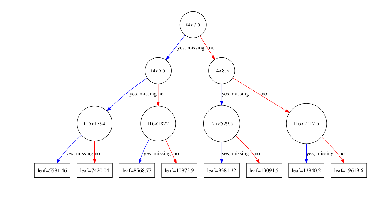

In [22]:
import xgboost as xgb
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
xgb.plot_tree(my_model, num_trees=2)
plt.show()

In [11]:
!pip install graphviz

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
